# Get individual customer's meter data

In [13]:
import pandas
import matplotlib.pyplot as plt

In [14]:
frame = pandas.read_csv('bulk_intervals_3000.csv')
frame['start'] = pandas.to_datetime(frame['start'], unit='s')
frame = frame.set_index(['meter_uid', 'start'])

In [15]:
frame.loc[4574]

,duration,kwh
start,,
2018-01-23 16:00:00,3600,0.16
2018-01-23 17:00:00,3600,0.15
2018-01-23 18:00:00,3600,0.15
2018-01-23 19:00:00,3600,0.16
2018-01-23 20:00:00,3600,0.16
...,...,...
2020-01-19 11:00:00,3600,0.75
2020-01-19 12:00:00,3600,0.31
2020-01-19 13:00:00,3600,0.30


# Get CAISO data

In [16]:
caiso = pandas.read_csv('caiso_processed.csv')
caiso['datetime'] = pandas.to_datetime(caiso['datetime'])
caiso = caiso.set_index('datetime')
caiso

,wind,solar,thermal
datetime,,,
2018-01-23 00:00:00,448,0,6976
2018-01-23 01:00:00,459,0,6657
2018-01-23 02:00:00,513,0,6462
2018-01-23 03:00:00,523,0,6380
2018-01-23 04:00:00,495,0,7083
...,...,...,...
2020-01-19 19:00:00,496,0,9591
2020-01-19 20:00:00,535,0,9747
2020-01-19 21:00:00,445,0,9754


# Merge Meter and CAISO data

In [17]:
merge = pandas.merge(frame.loc[4574], caiso, how='inner', left_index=True, right_index=True)
del merge['duration']
merge

,kwh,wind,solar,thermal
2018-01-23 16:00:00,0.16,185,1597,9214
2018-01-23 17:00:00,0.15,270,20,10881
2018-01-23 18:00:00,0.15,340,0,11159
2018-01-23 19:00:00,0.16,386,0,10905
2018-01-23 20:00:00,0.16,303,0,10572
...,...,...,...,...
2020-01-19 11:00:00,0.75,493,5822,5783
2020-01-19 12:00:00,0.31,495,5636,5797
2020-01-19 13:00:00,0.30,445,4229,6294
2020-01-19 14:00:00,0.21,369,3356,6739


In [18]:
merge['cef'] = (merge['wind']/merge['thermal'])*100 + (merge['solar']/merge['thermal'])*40
merge['personal_cef'] = merge['kwh'] * merge['cef']
merge

,kwh,wind,solar,thermal,cef,personal_cef
2018-01-23 16:00:00,0.16,185,1597,9214,8.940742,1.430519
2018-01-23 17:00:00,0.15,270,20,10881,2.554912,0.383237
2018-01-23 18:00:00,0.15,340,0,11159,3.046868,0.457030
2018-01-23 19:00:00,0.16,386,0,10905,3.539661,0.566346
2018-01-23 20:00:00,0.16,303,0,10572,2.866061,0.458570
...,...,...,...,...,...,...
2020-01-19 11:00:00,0.75,493,5822,5783,48.794743,36.596057
2020-01-19 12:00:00,0.31,495,5636,5797,47.427980,14.702674
2020-01-19 13:00:00,0.30,445,4229,6294,33.946616,10.183985
2020-01-19 14:00:00,0.21,369,3356,6739,25.395459,5.333046


In [32]:
hourly_merge = merge.groupby(by=merge.index.date).sum()

In [33]:
hourly_merge['weighted_cef'] = hourly_merge['personal_cef'] / hourly_merge['kwh']

In [34]:
hourly_merge.index = pandas.to_datetime(hourly_merge.index)
hourly_merge

,kwh,wind,solar,thermal,cef,personal_cef,weighted_cef
2018-01-23,1.30,2230,1617,79767,29.309025,4.740204,3.646310
2018-01-24,6.50,15936,54238,163330,721.818657,165.206271,25.416349
2018-01-25,5.92,57541,49407,132325,1728.972278,302.567641,51.109399
2018-01-26,16.44,34448,57844,134734,1273.815779,1116.749216,67.928784
2018-01-27,3.79,14209,58378,113190,1187.745169,217.802415,57.467656
...,...,...,...,...,...,...,...
2020-01-15,9.68,17974,54034,236926,451.733965,250.004693,25.826931
2020-01-16,4.49,37776,46671,221125,635.490789,119.967468,26.718813
2020-01-17,4.38,24971,47998,214879,547.226312,114.710640,26.189644
2020-01-18,3.64,9031,46098,196840,406.173939,69.245867,19.023590


In [40]:
monthly_merge = hourly_merge.groupby(by=[hourly_merge.index.year, hourly_merge.index.month]).sum()
monthly_merge['weighted_cef'] = monthly_merge['personal_cef'] / monthly_merge['kwh']
monthly_merge

kwh     wind    solar  thermal            cef  personal_cef  \
2018 1    46.14   197550   441825  1189876    8577.305386   2314.768226   
     2   153.33  1032173  1778193  4112735   45020.003081  10116.727144   
     3   209.30  1214111  2002979  4628041   43914.499482  12544.848784   
     4   206.27  1789726  2521840  3257736   94395.439300  24454.537407   
     5   202.98  2176415  2898885  2666709  132233.298296  32452.532546   
     6   197.20  1977360  3038305  3994793   87294.330620  25837.826867   
     7   369.63  1630866  2720443  8350802   27251.368577  14418.812624   
     8   262.84  1871900  2759891  7977677   32600.806324  12862.123605   
     9   262.21  1279477  2521970  5951558   32305.449878  12588.050267   
     10  247.06  1035049  2059045  6533867   25812.204833   8347.552369   
     11  165.14   906271  1542850  6154134   24153.044385   5600.208279   
     12  244.26   905832  1304648  5796807   26176.955587   8698.096947   
2019 1   223.10   714154  1399892  5603376   22913.039087   6957.858174   
     2   247.40  1195382  1524146  5716957   27331.554843  10975.745295   
     3   238.03  1239105  2203035  4758206   47997.438174  14165.078321   
     4   188.72  1753894  2572609  2982845   96285.008669  27159.039923   
     5   164.91  2003987  2704278  2606818  118561.673591  28534.442582   
     6   262.06  1842739  3145449  3427480  100981.750813  37248.890659   
     7   303.91  1922907  3216955  5871675   65451.472399  29313.255008   
     8   378.03  1609108  3115191  7077237   40829.792569  23996.016660   
     9   215.29  1091224  1987864  4527016   36221.446198  12647.820684   
     12  121.00   470204   792671  4376244   10005.862912   3159.583091   
2020 1   126.35   648036   916511  3444144   16392.629075   5102.166662   

         weighted_cef  
2018 1      50.168362  
     2      65.980090  
     3      59.937166  
     4     118.555958  
     5     159.880444  
     6     131.023463  
     7      39.008773  
     8      48.935183  
     9      48.007514  
     10     33.787551  
     11     33.911883  
     12     35.609993  
2019 1      31.187172  
     2      44.364371  
     3      59.509635  
     4     143.911827  
     5     173.030396  
     6     142.138788  
     7      96.453736  
     8      63.476488  
     9      58.747832  
     12     26.112257  
2020 1      40.381216

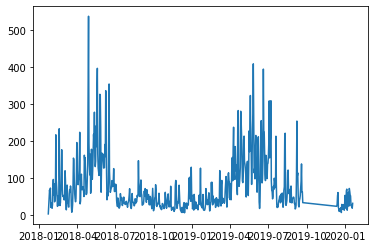

In [22]:
plt.plot(hourly_merge['weighted_cef'])

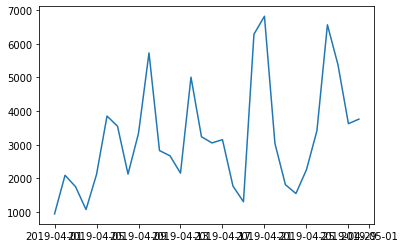

In [23]:
subframe = hourly_merge.loc['2019-04-01 00:00:00':'2019-04-30 23:00:00']
plt.plot(subframe['cef'])

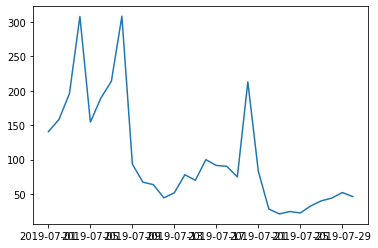

In [26]:
subframe = hourly_merge.loc['2019-07-01 00:00:00':'2019-07-30 23:00:00']
plt.plot(subframe['weighted_cef'])

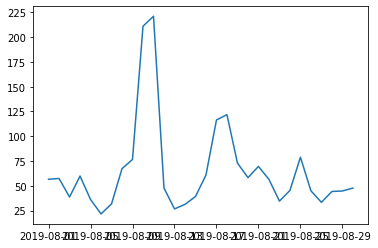

In [27]:
subframe = hourly_merge.loc['2019-08-01 00:00:00':'2019-08-30 23:00:00']
plt.plot(subframe['weighted_cef'])